# Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.font_manager as font_manager
from scipy.optimize import curve_fit
import math
from scipy.special import expit
from scipy import signal
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

# Division and Preprocessing Functions

In [2]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])
    zero = pd.DataFrame(data[data.flow_direction == 0])

    return right, left, zero

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def divide_C0(C0):
    C0 = C0.reset_index()
    C0['counter'] = 0
    counter = 0
    first_index = 0
    for i, r in C0[:-1].iterrows():
        if C0.iloc[i+1]['index'] - r['index'] != 1:
            counter +=1
            last_index = r['index']
            C0.loc[first_index:i,'counter'] = counter
            first_index = i+1
    
    C0_0 = pd.DataFrame(C0[C0.counter == 0]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_1 = pd.DataFrame(C0[C0.counter == 1]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_2 = pd.DataFrame(C0[C0.counter == 2]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_3 = pd.DataFrame(C0[C0.counter == 3]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_4 = pd.DataFrame(C0[C0.counter == 4]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_5 = pd.DataFrame(C0[C0.counter == 5]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_6 = pd.DataFrame(C0[C0.counter == 6]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_7 = pd.DataFrame(C0[C0.counter == 7]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_8 = pd.DataFrame(C0[C0.counter == 8]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_9 = pd.DataFrame(C0[C0.counter == 9]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_10 = pd.DataFrame(C0[C0.counter == 10]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_11 = pd.DataFrame(C0[C0.counter == 11]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_12 = pd.DataFrame(C0[C0.counter == 12]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    
    return C0_0, C0_1, C0_2, C0_3, C0_4, C0_5, C0_6, C0_7, C0_8, C0_9, C0_10, C0_11, C0_12

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])
    
    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.5:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']

    tstp = np.arange(0,30,30/len(new))
    if len(new['timestamp']) != len(tstp):
        tstp = tstp[:-1]
    tstpdate = pd.to_datetime(tstp,unit='s')
    new['timestamp'] = tstp
    new['tstpdate'] = tstpdate
    new = new.set_index('tstpdate')
    new_df = new.resample('10ms')
    new_df = new_df.first()
    new_df.interpolate(method='linear',inplace=True)

    interp = new_df.copy()
    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    #cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    #resetting index to integers
    interp = interp.reset_index()
    interp = interp.drop(columns=['tstpdate'])

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

In [3]:
# pm_Ze1 = pm_Ze1.reset_index()
# for i, r in pm_Ze1[:-1].iterrows():
#     if pm_Ze1.iloc[i+1]['index'] - r['index'] != 1:
#         last_index = r['index'] 
#         print(last_index)
#         print('-------')

# Reading and Preprocessing

In [4]:
for e in range(1,31):
    exec(f'pm_e{e} = pd.read_csv("../raw_data/PM/E2/xy_hc_fai_tstp_E2_{e}_PM.csv")')
    
for e in range(1,31):
    exec(f'pm_Re{e},pm_Le{e},pm_Ze{e} = divide_data_by_flow_direction(pm_e{e})')
    
for e in range(1,31):
    exec(f'pm_e_C0_{e}_0, pm_e_C0_{e}_1, pm_e_C0_{e}_2, pm_e_C0_{e}_3, pm_e_C0_{e}_4, pm_e_C0_{e}_5, pm_e_C0_{e}_6, pm_e_C0_{e}_7, pm_e_C0_{e}_8, pm_e_C0_{e}_9, \
            pm_e_C0_{e}_10, pm_e_C0_{e}_11, pm_e_C0_{e}_12 = divide_C0(pm_Ze{e})')
    
for n in ['0','1','2','3','4','5','6','7','8','9','10','11','12']:
    for e in range(1,31):
        exec(f'pm_e_C0_{e}_{n} = omr_preprocess(pm_e_C0_{e}_{n})')

# for flow in ['R','L']:
#     for e in range(1,19):
#         exec(f'pm_{flow}e{e}C_0, pm_{flow}e{e}C_1, pm_{flow}e{e}C_10, pm_{flow}e{e}C_20, pm_{flow}e{e}C_30, \
#             pm_{flow}e{e}C_50, pm_{flow}e{e}C_70, pm_{flow}e{e}C_100 = divide_data_by_contrast(pm_{flow}e{e})')

# for flow in ['R','L']:
#     for contrast in ['1','10','20','30','50','70','100']:
#         for e in range(1,19):
#             exec(f'pm_{flow}e{e}C_{contrast} = omr_preprocess(pm_{flow}e{e}C_{contrast})')

In [5]:
for me in range(1,34):
    exec(f'pm_me{me} = pd.read_csv("../raw_data/PM/Met/xy_hc_fai_tstp_Me_{me}_PM.csv")')
    
for me in range(1,34):
    exec(f'pm_Rme{me},pm_Lme{me},pm_Zme{me} = divide_data_by_flow_direction(pm_me{me})')

for me in range(1,34):
    exec(f'pm_me_C0_{me}_0, pm_me_C0_{me}_1, pm_me_C0_{me}_2, pm_me_C0_{me}_3, pm_me_C0_{me}_4, pm_me_C0_{me}_5, \
            pm_me_C0_{me}_6, pm_me_C0_{me}_7, pm_me_C0_{me}_8, pm_me_C0_{me}_9, pm_me_C0_{me}_10, pm_me_C0_{me}_11, \
            pm_me_C0_{me}_12 = divide_C0(pm_Zme{me})')
    
for n in ['0','1','2','3','4','5','6','7','8','9','10','11','12']:
    for me in range(1,34):
        exec(f'pm_me_C0_{me}_{n} = omr_preprocess(pm_me_C0_{me}_{n})')

# for flow in ['R','L','Z']:
#     for me in range(1,23):
#         exec(f'pm_{flow}me{me}C_0, pm_{flow}me{me}C_1, pm_{flow}me{me}C_10, pm_{flow}me{me}C_20, pm_{flow}me{me}C_30, \
#             pm_{flow}me{me}C_50, pm_{flow}me{me}C_70, pm_{flow}me{me}C_100 = divide_data_by_contrast(pm_{flow}me{me})')

# for flow in ['R','L']:
#     for contrast in ['1','10','20','30','50','70','100']:
#         for me in range(1,23):
#             exec(f'pm_{flow}me{me}C_{contrast} = omr_preprocess(pm_{flow}me{me}C_{contrast})')

In [6]:
for e in range(1,23):
    exec(f'am_e{e} = pd.read_csv("../raw_data/AM/E2/xy_hc_fai_tstp_E2_{e}_AM.csv")')

for e in range(1,23):
    exec(f'am_Re{e},am_Le{e},am_Ze{e} = divide_data_by_flow_direction(am_e{e})')

for e in range(1,23):
    exec(f'am_e_C0_{e}_0, am_e_C0_{e}_1, am_e_C0_{e}_2, am_e_C0_{e}_3, am_e_C0_{e}_4, am_e_C0_{e}_5, am_e_C0_{e}_6, am_e_C0_{e}_7, am_e_C0_{e}_8, am_e_C0_{e}_9, \
            am_e_C0_{e}_10, am_e_C0_{e}_11, am_e_C0_{e}_12 = divide_C0(am_Ze{e})')
    
for n in ['0','1','2','3','4','5','6','7','8','9','10','11','12']:
    for e in range(1,23):
        exec(f'am_e_C0_{e}_{n} = omr_preprocess(am_e_C0_{e}_{n})')
    
# for flow in ['R','L','Z']:
#     for e in range(1,17):
#         exec(f'am_{flow}e{e}C_0, am_{flow}e{e}C_1, am_{flow}e{e}C_10, am_{flow}e{e}C_20, am_{flow}e{e}C_30, \
#             am_{flow}e{e}C_50, am_{flow}e{e}C_70, am_{flow}e{e}C_100 = divide_data_by_contrast(am_{flow}e{e})')

# for flow in ['R','L']:
#     for contrast in ['1','10','20','30','50','70','100']:
#         for e in range(1,17):
#             exec(f'am_{flow}e{e}C_{contrast} = omr_preprocess(am_{flow}e{e}C_{contrast})')

In [7]:
for me in range(1,23):
    exec(f'am_me{me} = pd.read_csv("../raw_data/AM/Met/xy_hc_fai_tstp_Me_{me}_AM.csv")')
    
for me in range(1,23):
    exec(f'am_Rme{me},am_Lme{me},am_Zme{me} = divide_data_by_flow_direction(am_me{me})')

for me in range(1,23):
    exec(f'am_me_C0_{me}_0, am_me_C0_{me}_1, am_me_C0_{me}_2, am_me_C0_{me}_3, am_me_C0_{me}_4, am_me_C0_{me}_5, \
            am_me_C0_{me}_6, am_me_C0_{me}_7, am_me_C0_{me}_8, am_me_C0_{me}_9, am_me_C0_{me}_10, am_me_C0_{me}_11, \
            am_me_C0_{me}_12 = divide_C0(am_Zme{me})')
    
for n in ['0','1','2','3','4','5','6','7','8','9','10','11','12']:
    for me in range(1,23):
        exec(f'am_me_C0_{me}_{n} = omr_preprocess(am_me_C0_{me}_{n})')
# for flow in ['R','L','Z']:
#     for me in range(1,18):
#         exec(f'am_{flow}me{me}C_0, am_{flow}me{me}C_1, am_{flow}me{me}C_10, am_{flow}me{me}C_20, am_{flow}me{me}C_30,\
#         am_{flow}me{me}C_50, am_{flow}me{me}C_70, am_{flow}me{me}C_100 = divide_data_by_contrast(am_{flow}me{me})')

# for flow in ['R','L']:
#     for contrast in ['1','10','20','30','50','70','100']:
#         for me in range(1,18):
#             exec(f'am_{flow}me{me}C_{contrast} = omr_preprocess(am_{flow}me{me}C_{contrast})')

# Filter Data

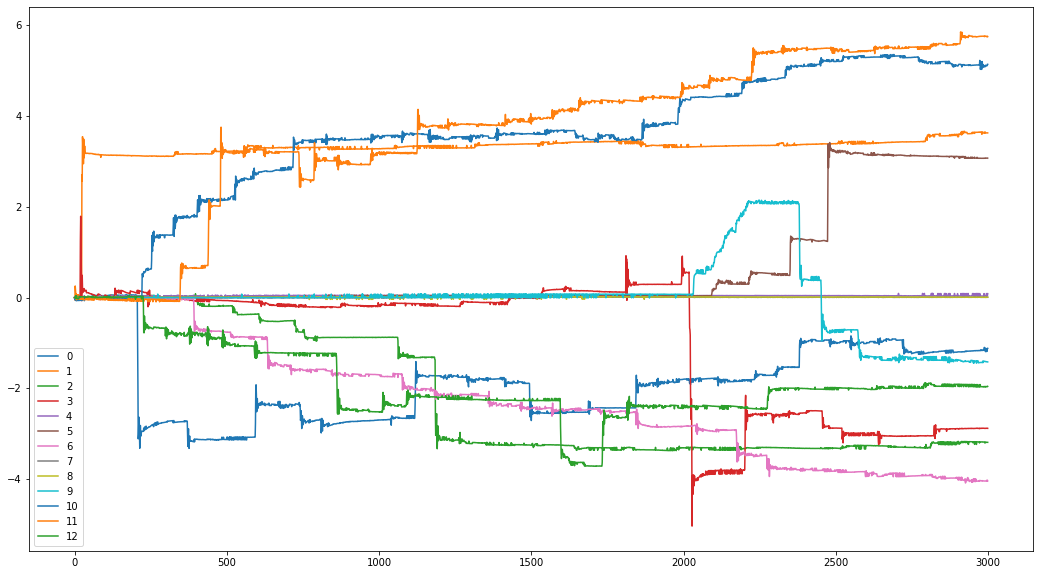

In [109]:
fig, ax = plt.subplots(1,1,figsize=(18,10))

plt.plot(am_me_C0_2_0[:,4], label='0')
plt.plot(am_me_C0_2_1[:,4], label='1')
plt.plot(am_me_C0_2_2[:,4], label='2')
plt.plot(am_me_C0_2_3[:,4], label='3')
plt.plot(am_me_C0_2_4[:,4], label='4')
plt.plot(am_me_C0_2_5[:,4], label='5')
plt.plot(am_me_C0_2_6[:,4], label='6')
plt.plot(am_me_C0_2_7[:,4], label='7')
plt.plot(am_me_C0_2_8[:,4], label='8')
plt.plot(am_me_C0_2_9[:,4], label='9')
plt.plot(am_me_C0_2_10[:,4], label='10')
plt.plot(am_me_C0_2_11[:,4], label='11')
plt.plot(am_me_C0_2_12[:,4], label='12')

plt.legend()

# Combine Fish Data

In [61]:
pm_comb_e = combine_fish_data(pm_e_C0_1_0,pm_e_C0_1_1,pm_e_C0_1_2,pm_e_C0_1_3,pm_e_C0_1_4,pm_e_C0_1_5,pm_e_C0_1_6,\
                              pm_e_C0_1_7,pm_e_C0_1_8,pm_e_C0_1_9,pm_e_C0_1_10,pm_e_C0_1_11,pm_e_C0_1_12,\
                              pm_e_C0_2_0,pm_e_C0_2_1,pm_e_C0_2_2,pm_e_C0_2_3,pm_e_C0_2_4,pm_e_C0_2_5,pm_e_C0_2_6,\
                              pm_e_C0_2_7,pm_e_C0_2_8,pm_e_C0_2_9,pm_e_C0_2_10,pm_e_C0_2_12,\
                              pm_e_C0_3_1,pm_e_C0_3_2,pm_e_C0_3_3,pm_e_C0_3_4,pm_e_C0_3_6,\
                              pm_e_C0_3_7,pm_e_C0_3_8,pm_e_C0_3_9,pm_e_C0_3_10,pm_e_C0_3_11,pm_e_C0_3_12,\
                              pm_e_C0_4_0,pm_e_C0_4_1,pm_e_C0_4_2,pm_e_C0_4_3,pm_e_C0_4_4,pm_e_C0_4_5,pm_e_C0_4_6,\
                              pm_e_C0_4_7,pm_e_C0_4_8,pm_e_C0_4_9,pm_e_C0_4_10,pm_e_C0_4_11,pm_e_C0_4_12,\
                              pm_e_C0_5_0,pm_e_C0_5_1,pm_e_C0_5_2,pm_e_C0_5_3,pm_e_C0_5_4,pm_e_C0_5_5,pm_e_C0_5_6,\
                              pm_e_C0_5_7,pm_e_C0_5_8,pm_e_C0_5_9,pm_e_C0_5_10,pm_e_C0_5_11,pm_e_C0_5_12,\
                              pm_e_C0_6_0,pm_e_C0_6_1,pm_e_C0_6_2,pm_e_C0_6_3,pm_e_C0_6_4,pm_e_C0_6_5,pm_e_C0_6_6,\
                              pm_e_C0_6_7,pm_e_C0_6_8,pm_e_C0_6_9,pm_e_C0_6_10,pm_e_C0_6_11,pm_e_C0_6_12,\
                              pm_e_C0_7_0,pm_e_C0_7_1,pm_e_C0_7_2,pm_e_C0_7_3,pm_e_C0_7_4,pm_e_C0_7_5,\
                              pm_e_C0_7_7,pm_e_C0_7_9,pm_e_C0_7_10,pm_e_C0_7_11,pm_e_C0_7_12,\
                              pm_e_C0_9_1,pm_e_C0_9_3,pm_e_C0_9_5,\
                              pm_e_C0_9_7,pm_e_C0_9_10,pm_e_C0_9_11,pm_e_C0_9_12,\
                              pm_e_C0_10_0,pm_e_C0_10_1,pm_e_C0_10_2,pm_e_C0_10_3,pm_e_C0_10_4,pm_e_C0_10_5,\
                              pm_e_C0_10_6,pm_e_C0_10_8,pm_e_C0_10_9,pm_e_C0_10_10,pm_e_C0_10_11,\
                              pm_e_C0_10_12,pm_e_C0_11_0,pm_e_C0_11_1,pm_e_C0_11_2,pm_e_C0_11_3,pm_e_C0_11_4,\
                              pm_e_C0_11_5,pm_e_C0_11_6,pm_e_C0_11_7,pm_e_C0_11_8,pm_e_C0_11_9,pm_e_C0_11_10,\
                              pm_e_C0_11_11,pm_e_C0_11_12,pm_e_C0_12_0,pm_e_C0_12_1,pm_e_C0_12_2,pm_e_C0_12_3,\
                              pm_e_C0_12_4,pm_e_C0_12_5,pm_e_C0_12_6,pm_e_C0_12_7,pm_e_C0_12_8,\
                              pm_e_C0_12_10,pm_e_C0_13_0,pm_e_C0_13_2,\
                              pm_e_C0_13_4,pm_e_C0_13_5,pm_e_C0_13_6,pm_e_C0_13_7,pm_e_C0_13_8,\
                              pm_e_C0_13_9,pm_e_C0_13_10,pm_e_C0_13_11,pm_e_C0_13_12,pm_e_C0_14_1,\
                              pm_e_C0_14_2,pm_e_C0_14_3,pm_e_C0_14_4,pm_e_C0_14_6,pm_e_C0_14_7,\
                              pm_e_C0_14_8,pm_e_C0_14_9,pm_e_C0_14_10,pm_e_C0_14_11,pm_e_C0_15_0,\
                              pm_e_C0_15_1,pm_e_C0_15_2,pm_e_C0_15_4,pm_e_C0_15_5,\
                              pm_e_C0_15_7,pm_e_C0_15_12,\
                              pm_e_C0_16_1,pm_e_C0_16_3,pm_e_C0_16_5,\
                              pm_e_C0_16_6,pm_e_C0_16_7,pm_e_C0_16_9,pm_e_C0_16_10,pm_e_C0_16_11,\
                              pm_e_C0_16_12,pm_e_C0_17_0,pm_e_C0_17_1,pm_e_C0_17_2,pm_e_C0_17_4,\
                              pm_e_C0_17_5,pm_e_C0_17_6,pm_e_C0_17_7,pm_e_C0_17_8,pm_e_C0_17_9,pm_e_C0_17_10,\
                              pm_e_C0_17_11,pm_e_C0_17_12,pm_e_C0_18_0,pm_e_C0_18_1,pm_e_C0_18_2,pm_e_C0_18_3,\
                              pm_e_C0_18_4,pm_e_C0_18_5,pm_e_C0_18_7,pm_e_C0_18_8,pm_e_C0_18_9,\
                              pm_e_C0_18_10,pm_e_C0_18_11,pm_e_C0_18_12,\
                              pm_e_C0_19_0,pm_e_C0_19_1,pm_e_C0_19_2,pm_e_C0_19_3,pm_e_C0_19_4,pm_e_C0_19_5,\
                              pm_e_C0_19_6,pm_e_C0_19_7,pm_e_C0_19_8,pm_e_C0_19_9,pm_e_C0_19_10,pm_e_C0_19_11,\
                              pm_e_C0_19_12,\
                              pm_e_C0_20_0,pm_e_C0_20_1,pm_e_C0_20_2,pm_e_C0_20_3,pm_e_C0_20_4,pm_e_C0_20_5,\
                              pm_e_C0_20_6,pm_e_C0_20_7,pm_e_C0_20_8,pm_e_C0_20_9,pm_e_C0_20_10,pm_e_C0_20_11,\
                              pm_e_C0_20_12,\
                              pm_e_C0_21_0,pm_e_C0_21_1,pm_e_C0_21_2,pm_e_C0_21_3,pm_e_C0_21_4,pm_e_C0_21_5,\
                              pm_e_C0_21_6,pm_e_C0_21_7,pm_e_C0_21_8,pm_e_C0_21_9,pm_e_C0_21_10,pm_e_C0_21_11,\
                              pm_e_C0_21_12,\
                              pm_e_C0_22_0,pm_e_C0_22_1,pm_e_C0_22_2,pm_e_C0_22_3,pm_e_C0_22_4,pm_e_C0_22_5,\
                              pm_e_C0_22_6,pm_e_C0_22_8,pm_e_C0_22_9,pm_e_C0_22_10,pm_e_C0_22_11,\
                              pm_e_C0_22_12,\
                              pm_e_C0_23_0,pm_e_C0_23_1,pm_e_C0_23_2,pm_e_C0_23_3,pm_e_C0_23_4,pm_e_C0_23_5,\
                              pm_e_C0_23_6,pm_e_C0_23_7,pm_e_C0_23_8,pm_e_C0_23_9,pm_e_C0_23_10,pm_e_C0_23_11,\
                              pm_e_C0_23_12,\
                              pm_e_C0_24_0,pm_e_C0_24_1,pm_e_C0_24_2,pm_e_C0_24_3,pm_e_C0_24_4,pm_e_C0_24_5,\
                              pm_e_C0_24_6,pm_e_C0_24_7,pm_e_C0_24_8,pm_e_C0_24_9,pm_e_C0_24_10,pm_e_C0_24_11,\
                              pm_e_C0_24_12,\
                              pm_e_C0_25_0,pm_e_C0_25_1,pm_e_C0_25_2,pm_e_C0_25_3,pm_e_C0_25_4,pm_e_C0_25_5,\
                              pm_e_C0_25_6,pm_e_C0_25_7,pm_e_C0_25_8,pm_e_C0_25_9,pm_e_C0_25_10,pm_e_C0_25_11,\
                              pm_e_C0_25_12,\
                              pm_e_C0_26_0,pm_e_C0_26_1,pm_e_C0_26_3,pm_e_C0_26_4,pm_e_C0_26_5,\
                              pm_e_C0_26_6,pm_e_C0_26_7,pm_e_C0_26_9,pm_e_C0_26_10,pm_e_C0_26_11,\
                              pm_e_C0_26_12,\
                              pm_e_C0_27_0,pm_e_C0_27_1,pm_e_C0_27_2,pm_e_C0_27_3,pm_e_C0_27_4,pm_e_C0_27_5,\
                              pm_e_C0_27_6,pm_e_C0_27_7,pm_e_C0_27_8,pm_e_C0_27_9,pm_e_C0_27_10,pm_e_C0_27_11,\
                              pm_e_C0_27_12,\
                              pm_e_C0_28_0,pm_e_C0_28_1,pm_e_C0_28_2,pm_e_C0_28_3,pm_e_C0_28_4,pm_e_C0_28_5,\
                              pm_e_C0_28_6,pm_e_C0_28_7,pm_e_C0_28_8,pm_e_C0_28_9,pm_e_C0_28_10,pm_e_C0_28_11,\
                              pm_e_C0_28_12,\
                              pm_e_C0_29_0,pm_e_C0_29_1,pm_e_C0_29_2,pm_e_C0_29_3,pm_e_C0_29_4,pm_e_C0_29_5,\
                              pm_e_C0_29_6,pm_e_C0_29_7,pm_e_C0_29_8,pm_e_C0_29_9,pm_e_C0_29_10,pm_e_C0_29_11,\
                              pm_e_C0_29_12,\
                              pm_e_C0_30_0,pm_e_C0_30_1,pm_e_C0_30_2,pm_e_C0_30_3,pm_e_C0_30_4,pm_e_C0_30_5,\
                              pm_e_C0_30_6,pm_e_C0_30_7,pm_e_C0_30_8,pm_e_C0_30_9,pm_e_C0_30_10,pm_e_C0_30_11,\
                              pm_e_C0_30_12)


In [62]:
am_comb_e = combine_fish_data(am_e_C0_1_0,am_e_C0_1_1,am_e_C0_1_4,am_e_C0_1_5,\
                              am_e_C0_1_7,am_e_C0_1_9,am_e_C0_1_12,\
                              am_e_C0_2_1,am_e_C0_2_2,am_e_C0_2_3,am_e_C0_2_4,am_e_C0_2_6,\
                              am_e_C0_2_7,am_e_C0_2_8,am_e_C0_2_9,am_e_C0_2_11,am_e_C0_2_12,\
                              am_e_C0_3_0,am_e_C0_3_1,am_e_C0_3_2,am_e_C0_3_3,am_e_C0_3_5,am_e_C0_3_6,\
                              am_e_C0_3_7,am_e_C0_3_8,am_e_C0_3_12,\
                              am_e_C0_4_1,am_e_C0_4_2,am_e_C0_4_3,am_e_C0_4_4,am_e_C0_4_5,am_e_C0_4_6,\
                              am_e_C0_4_7,am_e_C0_4_8,am_e_C0_4_9,am_e_C0_4_10,am_e_C0_4_11,am_e_C0_4_1,\
                              am_e_C0_6_0,am_e_C0_6_1,am_e_C0_6_2,am_e_C0_6_3,am_e_C0_6_4,am_e_C0_6_5,am_e_C0_6_6,\
                              am_e_C0_6_7,am_e_C0_6_9,am_e_C0_6_10,am_e_C0_6_11,am_e_C0_6_12,\
                              am_e_C0_7_0,am_e_C0_7_1,am_e_C0_7_2,am_e_C0_7_3,am_e_C0_7_4,am_e_C0_7_5,am_e_C0_7_6,\
                              am_e_C0_7_7,am_e_C0_7_9,am_e_C0_7_10,am_e_C0_7_12,\
                              am_e_C0_8_0,am_e_C0_8_1,am_e_C0_8_2,am_e_C0_8_3,am_e_C0_8_4,am_e_C0_8_5,am_e_C0_8_6,\
                              am_e_C0_8_7,am_e_C0_8_8,am_e_C0_8_9,am_e_C0_8_11,am_e_C0_8_12,\
                              am_e_C0_9_0,am_e_C0_9_1,am_e_C0_9_2,am_e_C0_9_3,am_e_C0_9_4,am_e_C0_9_5,am_e_C0_9_6,\
                              am_e_C0_9_7,am_e_C0_9_10,am_e_C0_9_11,am_e_C0_9_12,\
                              am_e_C0_10_3,am_e_C0_10_7,am_e_C0_10_10,am_e_C0_10_11,\
                              am_e_C0_11_0,am_e_C0_11_1,am_e_C0_11_2,\
                              am_e_C0_11_5,am_e_C0_11_6,am_e_C0_11_7,am_e_C0_11_8,am_e_C0_11_10,\
                              am_e_C0_11_12,am_e_C0_12_0,am_e_C0_12_2,am_e_C0_12_3,\
                              am_e_C0_12_4,am_e_C0_12_5,am_e_C0_12_6,am_e_C0_12_7,am_e_C0_12_8,am_e_C0_12_9,\
                              am_e_C0_12_10,am_e_C0_12_11,am_e_C0_12_12,am_e_C0_13_0,am_e_C0_13_1,am_e_C0_13_2,\
                              am_e_C0_13_4,am_e_C0_13_6,am_e_C0_13_8,\
                              am_e_C0_13_9,am_e_C0_13_10,am_e_C0_13_11,am_e_C0_13_12,am_e_C0_14_0,am_e_C0_14_1,\
                              am_e_C0_14_2,am_e_C0_14_3,am_e_C0_14_4,am_e_C0_14_5,am_e_C0_14_7,\
                              am_e_C0_14_8,am_e_C0_14_10,am_e_C0_14_12,am_e_C0_15_0,\
                              am_e_C0_15_1,am_e_C0_15_2,am_e_C0_15_3,am_e_C0_15_4,am_e_C0_15_5,am_e_C0_15_6,\
                              am_e_C0_15_7,am_e_C0_15_8,am_e_C0_15_9,am_e_C0_15_10,am_e_C0_15_11,am_e_C0_15_12,\
                              am_e_C0_16_0,am_e_C0_16_1,am_e_C0_16_2,am_e_C0_16_4,am_e_C0_16_5,\
                              am_e_C0_16_6,am_e_C0_16_7,am_e_C0_16_8,am_e_C0_16_9,am_e_C0_16_10,am_e_C0_16_11,\
                              am_e_C0_16_12,\
                              am_e_C0_18_1,am_e_C0_18_2,\
                              am_e_C0_19_0,am_e_C0_19_1,am_e_C0_19_2,am_e_C0_19_3,am_e_C0_19_4,am_e_C0_19_5,\
                              am_e_C0_19_6,am_e_C0_19_7,am_e_C0_19_8,am_e_C0_19_9,am_e_C0_19_10,am_e_C0_19_11,\
                              am_e_C0_19_12,\
                              am_e_C0_20_0,am_e_C0_20_1,am_e_C0_20_2,am_e_C0_20_3,am_e_C0_20_4,am_e_C0_20_5,\
                              am_e_C0_20_6,am_e_C0_20_7,am_e_C0_20_8,am_e_C0_20_9,am_e_C0_20_10,am_e_C0_20_11,\
                              am_e_C0_20_12,\
                              am_e_C0_21_0,am_e_C0_21_1,am_e_C0_21_2,am_e_C0_21_3,am_e_C0_21_4,am_e_C0_21_5,\
                              am_e_C0_21_6,am_e_C0_21_7,am_e_C0_21_8,am_e_C0_21_9,am_e_C0_21_10,am_e_C0_21_11,\
                              am_e_C0_21_12,\
                              am_e_C0_22_0,am_e_C0_22_1,am_e_C0_22_2,am_e_C0_22_3,am_e_C0_22_4,am_e_C0_22_5,\
                              am_e_C0_22_6,am_e_C0_22_7,am_e_C0_22_8,am_e_C0_22_9,am_e_C0_22_10,am_e_C0_22_11,\
                              am_e_C0_22_12)

In [63]:
pm_comb_me = combine_fish_data(pm_me_C0_1_0,pm_me_C0_1_2,pm_me_C0_1_3,pm_me_C0_1_4,pm_me_C0_1_5,\
                               pm_me_C0_1_7,pm_me_C0_1_8,pm_me_C0_1_9,pm_me_C0_1_10,pm_me_C0_1_11,\
                               pm_me_C0_1_12,pm_me_C0_2_0,pm_me_C0_2_2,pm_me_C0_2_3,pm_me_C0_2_4,\
                               pm_me_C0_2_5,pm_me_C0_2_6,pm_me_C0_2_7,pm_me_C0_2_8,pm_me_C0_2_9,pm_me_C0_2_10,\
                               pm_me_C0_2_11,pm_me_C0_2_12,pm_me_C0_3_1,pm_me_C0_3_2,pm_me_C0_3_3,\
                               pm_me_C0_3_4,pm_me_C0_3_5,pm_me_C0_3_6,pm_me_C0_3_7,pm_me_C0_3_8,pm_me_C0_3_9,\
                               pm_me_C0_3_10,pm_me_C0_3_11,pm_me_C0_3_12,pm_me_C0_4_0,pm_me_C0_4_1,pm_me_C0_4_2,\
                               pm_me_C0_4_3,pm_me_C0_4_4,pm_me_C0_4_5,pm_me_C0_4_6,pm_me_C0_4_7,pm_me_C0_4_8,\
                               pm_me_C0_4_9,pm_me_C0_4_10,pm_me_C0_4_11,pm_me_C0_4_12,pm_me_C0_5_0,pm_me_C0_5_1,\
                               pm_me_C0_5_2,pm_me_C0_5_3,pm_me_C0_5_4,pm_me_C0_5_5,pm_me_C0_5_6,pm_me_C0_5_7,\
                               pm_me_C0_5_8,pm_me_C0_5_9,pm_me_C0_5_10,pm_me_C0_5_11,pm_me_C0_5_12,pm_me_C0_6_0,\
                               pm_me_C0_6_1,pm_me_C0_6_2,pm_me_C0_6_3,pm_me_C0_6_4,pm_me_C0_6_5,pm_me_C0_6_6,\
                               pm_me_C0_6_7,pm_me_C0_6_8,pm_me_C0_6_9,pm_me_C0_6_10,pm_me_C0_6_11,pm_me_C0_6_12,\
                               pm_me_C0_7_0,pm_me_C0_7_1,pm_me_C0_7_2,pm_me_C0_7_3,pm_me_C0_7_4,pm_me_C0_7_5,\
                               pm_me_C0_7_6,pm_me_C0_7_7,pm_me_C0_7_8,pm_me_C0_7_9,pm_me_C0_7_10,pm_me_C0_7_11,\
                               pm_me_C0_7_12,pm_me_C0_8_0,pm_me_C0_8_1,pm_me_C0_8_2,pm_me_C0_8_3,pm_me_C0_8_4,\
                               pm_me_C0_8_5,pm_me_C0_8_6,pm_me_C0_8_7,pm_me_C0_8_9,pm_me_C0_8_10,\
                               pm_me_C0_8_11,pm_me_C0_8_12,pm_me_C0_9_0,pm_me_C0_9_1,pm_me_C0_9_3,\
                               pm_me_C0_9_8,pm_me_C0_9_9,\
                               pm_me_C0_9_10,pm_me_C0_9_11,pm_me_C0_9_12,pm_me_C0_10_0,pm_me_C0_10_1,pm_me_C0_10_2,\
                               pm_me_C0_10_3,pm_me_C0_10_4,pm_me_C0_10_6,pm_me_C0_10_7,pm_me_C0_10_8,\
                               pm_me_C0_10_9,pm_me_C0_10_10,pm_me_C0_10_11,pm_me_C0_10_12,pm_me_C0_11_0,\
                               pm_me_C0_11_1,pm_me_C0_11_2,pm_me_C0_11_3,pm_me_C0_11_4,pm_me_C0_11_5,\
                               pm_me_C0_11_7,pm_me_C0_11_9,pm_me_C0_11_10,\
                               pm_me_C0_12_0,pm_me_C0_12_2,pm_me_C0_12_3,pm_me_C0_12_4,\
                               pm_me_C0_12_5,pm_me_C0_12_7,pm_me_C0_12_8,pm_me_C0_12_9,pm_me_C0_12_10,\
                               pm_me_C0_12_11,pm_me_C0_12_12,pm_me_C0_13_1,pm_me_C0_13_2,\
                               pm_me_C0_13_4,pm_me_C0_13_5,pm_me_C0_13_6,pm_me_C0_13_8,\
                               pm_me_C0_13_10,pm_me_C0_13_11,pm_me_C0_13_12,pm_me_C0_14_0,\
                               pm_me_C0_14_1,pm_me_C0_14_2,pm_me_C0_14_4,pm_me_C0_14_5,pm_me_C0_14_6,\
                               pm_me_C0_14_7,pm_me_C0_14_8,pm_me_C0_14_10,pm_me_C0_14_11,\
                               pm_me_C0_14_12,pm_me_C0_15_0,pm_me_C0_15_1,pm_me_C0_15_2,pm_me_C0_15_3,\
                               pm_me_C0_15_6,pm_me_C0_15_10,\
                               pm_me_C0_15_11,pm_me_C0_15_12,pm_me_C0_16_1,pm_me_C0_16_2,pm_me_C0_16_3,\
                               pm_me_C0_16_5,pm_me_C0_16_6,pm_me_C0_16_7,pm_me_C0_16_8,pm_me_C0_16_9,\
                               pm_me_C0_16_10,pm_me_C0_16_11,pm_me_C0_16_12,pm_me_C0_17_0,pm_me_C0_17_1,\
                               pm_me_C0_17_2,pm_me_C0_17_3,pm_me_C0_17_5,pm_me_C0_17_6,pm_me_C0_17_7,\
                               pm_me_C0_17_10,pm_me_C0_17_11,pm_me_C0_17_12,\
                               pm_me_C0_18_0,pm_me_C0_18_1,pm_me_C0_18_3,pm_me_C0_18_4,pm_me_C0_18_5,\
                               pm_me_C0_18_6,pm_me_C0_18_7,pm_me_C0_18_9,pm_me_C0_18_10,\
                               pm_me_C0_18_12,pm_me_C0_19_0,pm_me_C0_19_2,pm_me_C0_19_3,pm_me_C0_19_4,\
                               pm_me_C0_19_5,pm_me_C0_19_6,\
                               pm_me_C0_19_11,pm_me_C0_20_0,pm_me_C0_20_1,pm_me_C0_20_2,pm_me_C0_20_3,\
                               pm_me_C0_20_4,pm_me_C0_20_5,pm_me_C0_20_6,pm_me_C0_20_7,pm_me_C0_20_8,pm_me_C0_20_9,\
                               pm_me_C0_20_12,pm_me_C0_21_0,pm_me_C0_21_1,\
                               pm_me_C0_21_2,pm_me_C0_21_3,pm_me_C0_21_4,pm_me_C0_21_5,pm_me_C0_21_6,pm_me_C0_21_7,\
                               pm_me_C0_21_8,pm_me_C0_21_9,pm_me_C0_21_10,pm_me_C0_21_11,pm_me_C0_21_12,\
                               pm_me_C0_22_0,pm_me_C0_22_1,pm_me_C0_22_2,pm_me_C0_22_3,pm_me_C0_22_4,pm_me_C0_22_5,\
                               pm_me_C0_22_6,pm_me_C0_22_8,pm_me_C0_22_9,pm_me_C0_22_10,pm_me_C0_22_11,\
                               pm_me_C0_22_12,\
                               pm_me_C0_23_0,pm_me_C0_23_1,pm_me_C0_23_2,pm_me_C0_23_3,pm_me_C0_23_4,pm_me_C0_23_5,\
                               pm_me_C0_23_6,pm_me_C0_23_7,pm_me_C0_23_8,pm_me_C0_23_9,pm_me_C0_23_10,pm_me_C0_23_11,\
                               pm_me_C0_23_12,\
                               pm_me_C0_24_0,pm_me_C0_24_1,pm_me_C0_24_2,pm_me_C0_24_4,pm_me_C0_24_5,\
                               pm_me_C0_24_6,pm_me_C0_24_7,pm_me_C0_24_8,pm_me_C0_24_9,pm_me_C0_24_10,pm_me_C0_24_11,\
                               pm_me_C0_24_12,\
                               pm_me_C0_25_0,pm_me_C0_25_1,pm_me_C0_25_2,pm_me_C0_25_3,pm_me_C0_25_4,pm_me_C0_25_5,\
                               pm_me_C0_25_7,pm_me_C0_25_8,pm_me_C0_25_9,pm_me_C0_25_10,pm_me_C0_25_11,\
                               pm_me_C0_25_12,\
                               pm_me_C0_26_0,pm_me_C0_26_1,pm_me_C0_26_3,pm_me_C0_26_4,pm_me_C0_26_5,\
                               pm_me_C0_26_6,pm_me_C0_26_7,pm_me_C0_26_8,pm_me_C0_26_9,pm_me_C0_26_10,pm_me_C0_26_11,\
                               pm_me_C0_26_12,\
                               pm_me_C0_27_0,pm_me_C0_27_1,pm_me_C0_27_2,pm_me_C0_27_3,pm_me_C0_27_4,pm_me_C0_27_5,\
                               pm_me_C0_27_6,pm_me_C0_27_7,pm_me_C0_27_8,pm_me_C0_27_9,pm_me_C0_27_10,pm_me_C0_27_11,\
                               pm_me_C0_27_12,\
                               pm_me_C0_28_0,pm_me_C0_28_1,pm_me_C0_28_2,pm_me_C0_28_3,pm_me_C0_28_4,pm_me_C0_28_5,\
                               pm_me_C0_28_6,pm_me_C0_28_7,pm_me_C0_28_8,pm_me_C0_28_9,pm_me_C0_28_10,pm_me_C0_28_11,\
                               pm_me_C0_28_12,\
                               pm_me_C0_29_0,pm_me_C0_29_1,pm_me_C0_29_2,pm_me_C0_29_3,pm_me_C0_29_4,pm_me_C0_29_5,\
                               pm_me_C0_29_6,pm_me_C0_29_7,pm_me_C0_29_8,pm_me_C0_29_9,pm_me_C0_29_10,pm_me_C0_29_11,\
                               pm_me_C0_29_12,\
                               pm_me_C0_30_0,pm_me_C0_30_1,pm_me_C0_30_2,pm_me_C0_30_3,pm_me_C0_30_4,pm_me_C0_30_5,\
                               pm_me_C0_30_6,pm_me_C0_30_7,pm_me_C0_30_8,pm_me_C0_30_9,pm_me_C0_30_10,pm_me_C0_30_11,\
                               pm_me_C0_30_12,\
                               pm_me_C0_31_0,pm_me_C0_31_1,pm_me_C0_31_2,pm_me_C0_31_3,pm_me_C0_31_4,pm_me_C0_31_5,\
                               pm_me_C0_31_6,pm_me_C0_31_7,pm_me_C0_31_8,pm_me_C0_31_9,pm_me_C0_31_10,pm_me_C0_31_11,\
                               pm_me_C0_31_12,\
                               pm_me_C0_32_0,pm_me_C0_32_1,pm_me_C0_32_2,pm_me_C0_32_3,pm_me_C0_32_4,pm_me_C0_32_5,\
                               pm_me_C0_32_6,pm_me_C0_32_7,pm_me_C0_32_8,pm_me_C0_32_9,pm_me_C0_32_10,pm_me_C0_32_11,\
                               pm_me_C0_32_12,\
                               pm_me_C0_33_0,pm_me_C0_33_1,pm_me_C0_33_2,pm_me_C0_33_3,pm_me_C0_33_4,pm_me_C0_33_5,\
                               pm_me_C0_33_6,pm_me_C0_33_7,pm_me_C0_33_8,pm_me_C0_33_9,pm_me_C0_33_10,pm_me_C0_33_11,\
                               pm_me_C0_33_12)

In [64]:
am_comb_me = combine_fish_data(am_me_C0_1_0,am_me_C0_1_1,am_me_C0_1_2,am_me_C0_1_3,am_me_C0_1_4,am_me_C0_1_5,\
                               am_me_C0_1_6,am_me_C0_1_7,am_me_C0_1_8,am_me_C0_1_9,am_me_C0_1_10,am_me_C0_1_11,\
                               am_me_C0_1_12,am_me_C0_2_0,am_me_C0_2_2,am_me_C0_2_3,am_me_C0_2_4,\
                               am_me_C0_2_5,am_me_C0_2_6,am_me_C0_2_7,am_me_C0_2_8,am_me_C0_2_10,\
                               am_me_C0_2_11,am_me_C0_2_12,am_me_C0_3_0,am_me_C0_3_1,am_me_C0_3_2,am_me_C0_3_3,\
                               am_me_C0_3_4,am_me_C0_3_5,am_me_C0_3_6,am_me_C0_3_7,am_me_C0_3_8,am_me_C0_3_9,\
                               am_me_C0_3_10,am_me_C0_3_11,am_me_C0_3_12,am_me_C0_4_0,am_me_C0_4_1,am_me_C0_4_2,\
                               am_me_C0_4_3,am_me_C0_4_4,am_me_C0_4_5,am_me_C0_4_6,am_me_C0_4_7,am_me_C0_4_8,\
                               am_me_C0_4_9,am_me_C0_4_11,am_me_C0_5_0,am_me_C0_5_1,\
                               am_me_C0_5_3,am_me_C0_5_5,am_me_C0_5_6,am_me_C0_5_7,\
                               am_me_C0_5_8,am_me_C0_5_9,am_me_C0_5_11,am_me_C0_5_12,am_me_C0_6_0,\
                               am_me_C0_6_1,am_me_C0_6_2,am_me_C0_6_3,am_me_C0_6_4,am_me_C0_6_5,am_me_C0_6_6,\
                               am_me_C0_6_7,am_me_C0_6_8,am_me_C0_6_9,am_me_C0_6_10,am_me_C0_6_11,am_me_C0_6_12,\
                               am_me_C0_7_0,am_me_C0_7_1,am_me_C0_7_2,am_me_C0_7_3,am_me_C0_7_4,\
                               am_me_C0_7_6,am_me_C0_7_7,am_me_C0_7_8,am_me_C0_7_9,am_me_C0_7_10,am_me_C0_7_11,\
                               am_me_C0_7_12,am_me_C0_8_0,am_me_C0_8_2,am_me_C0_8_3,am_me_C0_8_4,\
                               am_me_C0_8_5,am_me_C0_8_9,am_me_C0_8_10,\
                               am_me_C0_8_12,am_me_C0_10_0,\
                               am_me_C0_10_3,am_me_C0_10_5,am_me_C0_10_7,am_me_C0_10_8,\
                               am_me_C0_10_10,am_me_C0_10_11,am_me_C0_10_12,\
                               am_me_C0_11_1,am_me_C0_11_2,am_me_C0_11_3,am_me_C0_11_4,am_me_C0_11_6,\
                               am_me_C0_11_7,am_me_C0_11_8,am_me_C0_11_9,am_me_C0_11_10,am_me_C0_11_11,\
                               am_me_C0_11_12,am_me_C0_12_0,am_me_C0_12_1,am_me_C0_12_2,am_me_C0_12_3,\
                               am_me_C0_12_5,am_me_C0_12_7,am_me_C0_12_8,\
                               am_me_C0_12_12,am_me_C0_13_0,am_me_C0_13_1,am_me_C0_13_2,\
                               am_me_C0_13_3,am_me_C0_13_4,am_me_C0_13_5,am_me_C0_13_6,am_me_C0_13_7,am_me_C0_13_8,\
                               am_me_C0_13_10,am_me_C0_13_11,am_me_C0_13_12,am_me_C0_14_0,\
                               am_me_C0_14_1,am_me_C0_14_2,am_me_C0_14_3,am_me_C0_14_4,am_me_C0_14_5,am_me_C0_14_6,\
                               am_me_C0_14_7,am_me_C0_14_8,am_me_C0_14_9,am_me_C0_14_10,am_me_C0_14_11,\
                               am_me_C0_14_12,am_me_C0_15_0,am_me_C0_15_1,am_me_C0_15_2,am_me_C0_15_3,am_me_C0_15_4,\
                               am_me_C0_15_5,am_me_C0_15_6,am_me_C0_15_7,am_me_C0_15_9,am_me_C0_15_10,\
                               am_me_C0_15_11,am_me_C0_15_12,am_me_C0_16_0,am_me_C0_16_1,am_me_C0_16_2,am_me_C0_16_3,\
                               am_me_C0_16_4,am_me_C0_16_5,am_me_C0_16_6,am_me_C0_16_7,am_me_C0_16_8,am_me_C0_16_9,\
                               am_me_C0_16_10,am_me_C0_16_11,am_me_C0_16_12,am_me_C0_17_0,am_me_C0_17_1,\
                               am_me_C0_17_2,am_me_C0_17_3,am_me_C0_17_4,am_me_C0_17_5,am_me_C0_17_6,am_me_C0_17_7,\
                               am_me_C0_17_8,am_me_C0_17_9,am_me_C0_17_10,am_me_C0_17_11,am_me_C0_17_12,\
                               am_me_C0_18_0,am_me_C0_18_1,am_me_C0_18_2,am_me_C0_18_3,am_me_C0_18_4,am_me_C0_18_5,\
                               am_me_C0_18_6,am_me_C0_18_7,am_me_C0_18_8,am_me_C0_18_9,am_me_C0_18_10,am_me_C0_18_11,\
                               am_me_C0_18_12,\
                               am_me_C0_19_0,am_me_C0_19_1,am_me_C0_19_2,am_me_C0_19_3,am_me_C0_19_4,am_me_C0_19_5,\
                               am_me_C0_19_6,am_me_C0_19_7,am_me_C0_19_8,am_me_C0_19_9,am_me_C0_19_10,am_me_C0_19_11,\
                               am_me_C0_19_12,\
                               am_me_C0_20_0,am_me_C0_20_1,am_me_C0_20_2,am_me_C0_20_3,am_me_C0_20_4,am_me_C0_20_5,\
                               am_me_C0_20_6,am_me_C0_20_7,am_me_C0_20_8,am_me_C0_20_9,am_me_C0_20_10,am_me_C0_20_11,\
                               am_me_C0_20_12,\
                               am_me_C0_21_0,am_me_C0_21_1,am_me_C0_21_2,am_me_C0_21_3,am_me_C0_21_4,am_me_C0_21_5,\
                               am_me_C0_21_7,am_me_C0_21_8,am_me_C0_21_9,am_me_C0_21_10,am_me_C0_21_11,\
                               am_me_C0_21_12,\
                               am_me_C0_22_0,am_me_C0_22_1,am_me_C0_22_3,am_me_C0_22_4,am_me_C0_22_5,\
                               am_me_C0_22_6,am_me_C0_22_7,am_me_C0_22_8,am_me_C0_22_9,am_me_C0_22_10,am_me_C0_22_11,\
                               am_me_C0_22_12)

--------

# Plotting Average Trajectories

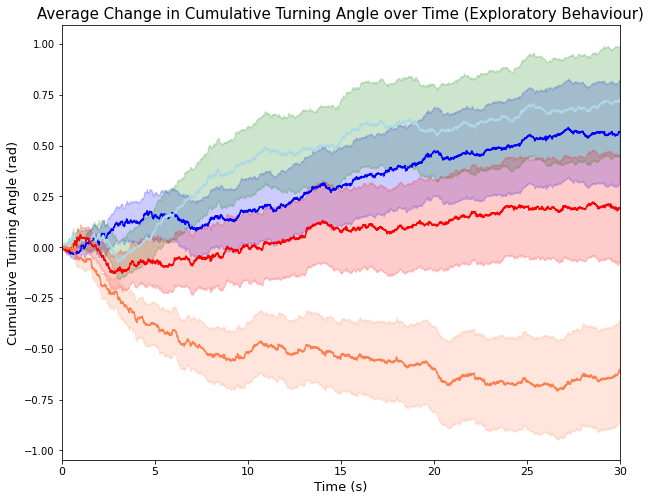

In [66]:
avg_pm_e_trajectory = np.mean(pm_comb_e[:,:,4],axis=0)
avg_pm_me_trajectory = np.mean(pm_comb_me[:,:,4],axis=0)

avg_pm_e_SEM = stats.sem(pm_comb_e[:,:,4],axis=0)
avg_pm_me_SEM = stats.sem(pm_comb_me[:,:,4],axis=0)
    
avg_am_e_trajectory = np.mean(am_comb_e[:,:,4],axis=0)
avg_am_me_trajectory = np.mean(am_comb_me[:,:,4],axis=0)

avg_am_e_SEM = stats.sem(am_comb_e[:,:,4],axis=0)
avg_am_me_SEM = stats.sem(am_comb_me[:,:,4],axis=0)

fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.title("Average Change in Cumulative Turning Angle over Time (Exploratory Behaviour)",fontsize=15)
ax.set_xlabel("Time (s)",fontsize=13)
ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)
ax.set_xlim(0,3000)
x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]
x_labels = [0, 5, 10, 15, 20, 25, 30] 
plt.xticks(x_ticks,x_labels,fontsize=11)
ax.plot(avg_pm_e_trajectory,c="b")
ax.plot(avg_pm_me_trajectory,c="lightblue")
ax.plot(avg_am_e_trajectory,c="r")
ax.plot(avg_am_me_trajectory,c="coral")
ax.fill_between(range(0,3000), avg_pm_e_trajectory-avg_pm_e_SEM, avg_pm_e_trajectory+avg_pm_e_SEM,color="b",alpha=0.2)
ax.fill_between(range(0,3000), avg_pm_me_trajectory-avg_pm_me_SEM, avg_pm_me_trajectory+avg_pm_me_SEM,\
                color="g",alpha=0.2)
ax.fill_between(range(0,3000), avg_am_e_trajectory-avg_am_e_SEM, avg_am_e_trajectory+avg_am_e_SEM,color="r",alpha=0.2)
ax.fill_between(range(0,3000), avg_am_me_trajectory-avg_am_me_SEM, avg_am_me_trajectory+avg_am_me_SEM,\
                color="coral",alpha=0.2)
plt.show()

# Calculation of Mean and SEM of Cumulative Angles

In [67]:
am_e_cum = am_comb_e[:,-1,4]
am_me_cum = am_comb_me[:,-1,4]
pm_e_cum = pm_comb_e[:,-1,4]
pm_me_cum = pm_comb_me[:,-1,4]

<BarContainer object of 4 artists>

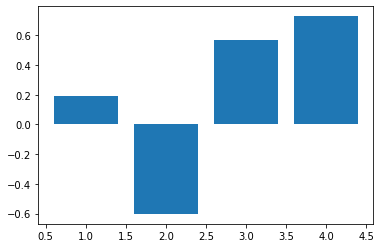

In [146]:
plt.bar([1,2,3,4],height=[(np.mean(am_e_cum)),(np.mean(am_me_cum)),(np.mean(pm_e_cum)),(np.mean(pm_me_cum))])

In [68]:
am_e_dist = np.mean(am_comb_e[:,:,5],axis=1)
am_me_dist = np.mean(am_comb_me[:,:,5],axis=1)
pm_e_dist = np.mean(pm_comb_e[:,:,5],axis=1)
pm_me_dist = np.mean(pm_comb_me[:,:,5],axis=1)

<BarContainer object of 4 artists>

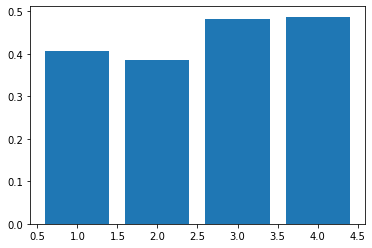

In [75]:
plt.bar([1,2,3,4],height=[np.mean(am_e_dist),np.mean(am_me_dist),np.mean(pm_e_dist),np.mean(pm_me_dist)])

In [70]:
am_e_sem = stats.sem(am_comb_e[:,-1,4])
am_me_sem = stats.sem(am_comb_me[:,-1,4])
pm_e_sem = stats.sem(pm_comb_e[:,-1,4])
pm_me_sem = stats.sem(pm_comb_me[:,-1,4])

(-1.0, 2.0)

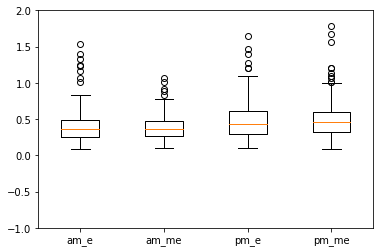

In [71]:
plt.boxplot([am_e_dist,am_me_dist,pm_e_dist,pm_me_dist],labels=['am_e','am_me','pm_e','pm_me'])
plt.ylim(-1,2)

{'whiskers': [<matplotlib.lines.Line2D at 0x131f4fd90>,
 'caps': [<matplotlib.lines.Line2D at 0x131f6c7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x131f6c0a0>,
 'medians': [<matplotlib.lines.Line2D at 0x131f6cd90>,
 'fliers': [<matplotlib.lines.Line2D at 0x131f790a0>,
 'means': []}

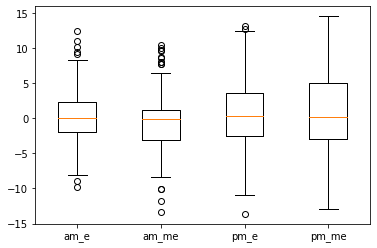

In [72]:
plt.boxplot([am_e_cum,am_me_cum,pm_e_cum,pm_me_cum],labels=['am_e','am_me','pm_e','pm_me'])

# Event Table Function

In [76]:
def make_event_table(contrast): 
    fish_distance = contrast[:,-1]
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)
    t = np.arange(0, 3000, 1)
    sig = fish_distance #composite signal
    sig_clean = sig #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()
    widths = np.arange(1, 3000)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    t = np.arange(0, 3000, 1)
    cwt_sig = cwtmatr[25,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()
    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
    ## Filter out noise
    threshold = 1
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal
    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform
    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)
    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=1:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2
    
    # fiter out events mid-beginning and mid-end 
    if fft_gauss[0] != 0:
        zero_start = fft_gauss.index(0)
        fft_gauss[:zero_start] = [0]*(zero_start)
    if fft_gauss[-1] != 0:
        end_zero = -(fft_gauss[::-1].index(0))
        fft_gauss[end_zero:] = [0]*(-end_zero) 
    

    indices = []
    for val in fft_gauss:
        if val == 0:
            indices.append(0)
        else:
            indices.append(fft_gauss.index(val))


    df = pd.DataFrame(fft_gauss,columns=['fft_gauss'])
    df['ind'] = indices
    df['init_cum'] = contrast[:,4]
    df['init_dist'] = contrast[:,5]
    df['event'] = 0


    counter = 1 
    for index, row in df.iterrows():  
        if row['fft_gauss'] != 0:
            df.at[index,'event'] = counter
            if df.at[index+1,'fft_gauss'] == 0:
                counter += 1


    event_df = pd.DataFrame(columns=['event','duration_s','delta_theta_rad','distance','start_ind','end_ind','latency_s'])
    event_df['event'] = df['event'].unique()[1:]

    event_df['duration_s'] = [((df['event']==event).sum())/100 for event in (df['event']).unique()[1:]]

    event_df['start_ind'] = [int(df[df['event']==event].reset_index().iloc[0][0]) for event in (df['event']).unique()[1:]]
    event_df['end_ind'] = [int(df[df['event']==event].reset_index().iloc[-1][0]) for event in (df['event']).unique()[1:]]

    event_df['delta_theta_rad'] = [df['init_cum'][r['end_ind']]-df['init_cum'][r['start_ind']] \
                                   for i, r in event_df.iterrows()]

    event_df['latency_s'] = [None if i-1 == -1 else (event_df['start_ind'][i]-event_df['end_ind'][i-1])/100 \
                             for i, r in event_df.iterrows()]

    # event_df['distance'] = ADD all frames per event except first one
    event_df['distance'] = [df[df['event']==ev]['init_dist'].sum() - df[df['event']==ev]['init_dist'].reset_index()\
                            ['init_dist'][0] for ev in df['event'].unique()[1:]]

    event_df = event_df.drop(columns=['start_ind','end_ind'])
    
    return event_df

# Making Event Table

In [77]:
df_names = ['am_e','am_me','pm_e','pm_me']
dataframes = [am_comb_e, am_comb_me, pm_comb_e, pm_comb_me]

In [78]:
full_event_table = pd.DataFrame(columns=['event_n','fish_n','event','duration_s','delta_theta_rad','distance',\
                                         'latency_s','time','medium'])

fish_counter = 1
for name,df in zip(df_names,dataframes):
    for fish in df:
        event_df = make_event_table(fish)
        event_df['time'] = name.split('_')[0]
        event_df['medium'] = name.split('_')[1]
        event_df['event_n'] = 0
        event_df['fish_n'] = fish_counter
        fish_counter += 1
        full_event_table = pd.concat([full_event_table,event_df])
        
full_event_table['event_n'] = np.arange(1,len(full_event_table)+1,1)
full_event_table = full_event_table.set_index('event_n')

full_event_table

,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium
event_n,,,,,,,,
1,1,1,0.43,-1.04943,48.73492,NaN,am,e
2,1,2,0.43,-0.555558,50.856764,0.48,am,e
3,1,3,0.35,0.042647,25.194393,0.82,am,e
4,1,4,0.39,0.832773,40.258041,0.53,am,e
5,1,5,0.39,-0.250422,41.238509,0.5,am,e
...,...,...,...,...,...,...,...,...
18617,1175,16,0.44,0.04684,54.326619,0.5,pm,me
18618,1175,17,0.44,-0.0102,45.728909,0.92,pm,me
18619,1175,18,0.45,-0.00763,45.071495,0.6,pm,me


In [108]:
full_event_table.to_csv('../raw_data/full_event_table_contrast_zero.csv')

In [80]:
am_events = full_event_table[full_event_table['time']=='am']
pm_events = full_event_table[full_event_table['time']=='pm']

In [115]:
pm_e_events = pm_events[pm_events['medium'] == 'e']
pm_me_events = pm_events[pm_events['medium'] == 'me']

In [122]:
am_e_events = am_events[am_events['medium'] == 'e']
am_me_events = am_events[am_events['medium'] == 'me']

In [119]:
pm_events['delta_theta_rad'] = pd.to_numeric(pm_events['delta_theta_rad'])
am_events['delta_theta_rad'] = pd.to_numeric(am_events['delta_theta_rad'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_59186/3814121538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_events['delta_theta_rad'] = pd.to_numeric(pm_events['delta_theta_rad'])
/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_59186/3814121538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_events['delta_theta_rad'] = pd.to_numeric(am_events['delta_theta_rad'])


In [81]:
full_event_table['delta_theta_rad'] = pd.to_numeric(full_event_table['delta_theta_rad'])
full_event_table['latency_s'] = pd.to_numeric(full_event_table['latency_s'])
full_event_table['distance'] = pd.to_numeric(full_event_table['distance'])

In [82]:
bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=full_event_table).fit()
anova_table_bout = sm.stats.anova_lm(bout_angle_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,1.611079,1.0,3.084457,0.079060
"C(medium, Sum)",3.878860,1.0,7.426190,0.006434
"C(time, Sum)",7.876980,1.0,15.080706,0.000103
"C(medium, Sum):C(time, Sum)",5.583661,1.0,10.690080,0.001079
Residual,9724.063616,18617.0,NaN,NaN


In [117]:
stats.f_oneway(pm_e_events['delta_theta_rad'],pm_me_events['delta_theta_rad'])

F_onewayResult(statistic=0.2552948520979683, pvalue=0.6133797226577578)

In [121]:
stats.f_oneway(am_e_events['delta_theta_rad'],am_me_events['delta_theta_rad'])

F_onewayResult(statistic=12.301791792498948, pvalue=0.00045614680647296316)

In [125]:
am_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum)'\
                       ,data=am_events).fit()
am_anova_table_bout = sm.stats.anova_lm(am_bout_angle_model, typ=3)
am_anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,0.837648,1.0,1.548902,0.213351
"C(medium, Sum)",6.652824,1.0,12.301792,0.000456
Residual,2968.457813,5489.0,NaN,NaN


In [127]:
print('AM E2: ',np.mean(am_e_events['delta_theta_rad']))
print('AM Met: ',np.mean(am_me_events['delta_theta_rad']))

AM E2:  0.02250710070218584
AM Met:  -0.04726462820081347


<BarContainer object of 2 artists>

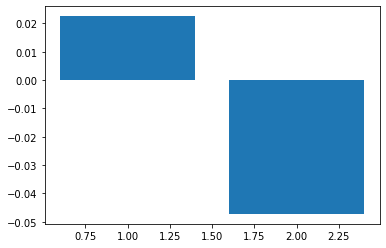

In [129]:
plt.bar([1,2],[np.mean(am_e_events['delta_theta_rad']), np.mean(am_me_events['delta_theta_rad'])])

In [114]:
pm_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum)'\
                       ,data=pm_events).fit()
pm_anova_table_bout = sm.stats.anova_lm(pm_bout_angle_model, typ=3)
pm_anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,14.095225,1.0,27.390899,1.687734e-07
"C(medium, Sum)",0.131374,1.0,0.255295,6.133797e-01
Residual,6755.605803,13128.0,NaN,NaN


In [83]:
latency_model = ols(formula='latency_s ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=full_event_table).fit()
anova_table_latency = sm.stats.anova_lm(latency_model, typ=3)
anova_table_latency

,sum_sq,df,F,PR(>F)
Intercept,17921.366052,1.0,13255.356225,0.000000e+00
"C(medium, Sum)",5.308103,1.0,3.926085,4.755809e-02
"C(time, Sum)",402.297526,1.0,297.555276,3.941694e-66
"C(medium, Sum):C(time, Sum)",12.157172,1.0,8.991929,2.715547e-03
Residual,23727.764753,17550.0,NaN,NaN


In [84]:
distance_model = ols(formula='distance ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=full_event_table).fit()
anova_table_distance = sm.stats.anova_lm(distance_model, typ=3)
anova_table_distance

,sum_sq,df,F,PR(>F)
Intercept,4.174815e+07,1.0,6074.158336,0.000000
"C(medium, Sum)",3.868085e+02,1.0,0.056279,0.812480
"C(time, Sum)",4.301213e+03,1.0,0.625806,0.428908
"C(medium, Sum):C(time, Sum)",3.241665e+03,1.0,0.471647,0.492239
Residual,1.279560e+08,18617.0,NaN,NaN


# Fish List

In [87]:
def sem_with_zero_division_exception(events,fish):
    try:
        return stats.sem(events.loc[(events['fish_n']==fish)]['latency_s'][1:]) 
    except ZeroDivisionError as e:
        return None

def make_fish_list(events):    
    fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance'])


    fish_list['fish_n'] = [fish for fish in events['fish_n'].unique()]
    fish_list['bouts_Hz'] = [events.loc[(events['fish_n']==fish)].max()[1]/30 \
                             for fish in events['fish_n'].unique()]
    fish_list['duration_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['duration_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['latency_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['latency_s']) \
                                for fish in events['fish_n'].unique()]
    fish_list['latency_sem'] = [sem_with_zero_division_exception(events,fish) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['distance']) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['distance']) \
                               for fish in events['fish_n'].unique()]
    fish_list['total_distance'] = [events.loc[(events['fish_n']==fish)]['distance'].sum() \
                                  for fish in events['fish_n'].unique()]
    # fish_list['final_cumulative_angle'] = None

    return fish_list

In [88]:
am_e_events = full_event_table[(full_event_table['time']=='am')&(full_event_table['medium']=='e')]
am_me_events = full_event_table[(full_event_table['time']=='am')&(full_event_table['medium']=='me')]
pm_e_events = full_event_table[(full_event_table['time']=='pm')&(full_event_table['medium']=='e')]
pm_me_events = full_event_table[(full_event_table['time']=='pm')&(full_event_table['medium']=='me')]

In [89]:
event_names = ['am_e','am_me','pm_e','pm_me']
event_dataframes = [am_e_events, am_me_events, pm_e_events, pm_me_events]

In [90]:
full_fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance','time',\
                                       'medium'])

for name,df in zip(event_names,event_dataframes):
    fish_list = make_fish_list(df)
    fish_list['time'] = name.split('_')[0]
    fish_list['medium'] = name.split('_')[1]
    fish_counter += 1
    full_fish_list = pd.concat([full_fish_list,fish_list])
        
full_fish_list['fish_n'] = np.arange(1,len(full_fish_list)+1,1)
full_fish_list = full_fish_list.set_index('fish_n')

full_fish_list

/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-pac

,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium
fish_n,,,,,,,,,,
1,0.766667,0.40913,0.008572,0.750909,0.065864,38.813441,1.73373,892.709137,am,e
2,0.5,0.475333,0.010773,1.42,0.359013,75.186549,6.207864,1127.798233,am,e
3,0.5,0.391333,0.024492,1.417857,0.43481,41.338405,4.441679,620.076073,am,e
4,0.333333,0.435,0.021871,1.228889,0.202062,59.296899,12.86991,592.968985,am,e
5,0.333333,0.36,0.023094,1.132222,0.205005,27.572011,2.798647,275.720112,am,e
...,...,...,...,...,...,...,...,...,...,...
1063,0.633333,0.395263,0.026072,1.177778,0.217302,58.400362,9.624673,1109.606878,pm,me
1064,0.833333,0.3768,0.022171,0.83875,0.132721,50.249085,4.390031,1256.227137,pm,me
1065,0.7,0.42,0.010976,0.999,0.170133,51.578868,3.652145,1083.15623,pm,me


In [91]:
am_fish_list = full_fish_list[full_fish_list['time']=='am']
pm_fish_list = full_fish_list[full_fish_list['time']=='pm']

In [92]:
am_e_fish_list = am_fish_list[am_fish_list['medium']=='e']
am_me_fish_list = am_fish_list[am_fish_list['medium']=='me']

pm_e_fish_list = pm_fish_list[pm_fish_list['medium']=='e']
pm_me_fish_list = pm_fish_list[pm_fish_list['medium']=='me']

In [93]:
full_fish_list['bouts_Hz'] = pd.to_numeric(full_fish_list['bouts_Hz'])
full_fish_list['latency_avg'] = pd.to_numeric(full_fish_list['latency_avg'])
full_fish_list['distance_avg'] = pd.to_numeric(full_fish_list['distance_avg'])
full_fish_list['total_distance'] = pd.to_numeric(full_fish_list['total_distance'])
full_fish_list['duration_avg'] = pd.to_numeric(full_fish_list['duration_avg'])

<BarContainer object of 2 artists>

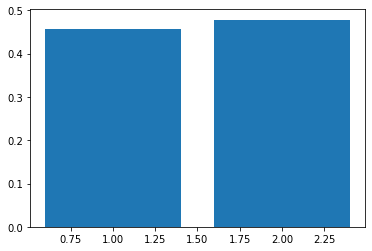

In [94]:
plt.bar([1,2],height=[np.mean(am_e_fish_list['bouts_Hz']),np.mean(am_me_fish_list['bouts_Hz'])])

In [95]:
bouts_hz_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=full_fish_list).fit()
anova_table_bouts_hz = sm.stats.anova_lm(bouts_hz_model, typ=3)
anova_table_bouts_hz

,sum_sq,df,F,PR(>F)
Intercept,307.249652,1.0,4478.132028,0.000000e+00
"C(medium, Sum)",0.036414,1.0,0.530727,4.664617e-01
"C(time, Sum)",7.983155,1.0,116.353662,8.155800e-26
"C(medium, Sum):C(time, Sum)",0.023598,1.0,0.343943,5.576868e-01
Residual,72.933620,1063.0,NaN,NaN


In [96]:
pg.welch_anova(data=full_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,1022.239316,0.3891,0.532912,0.000369


In [99]:
am_fish_list['bouts_Hz'] = pd.to_numeric(am_fish_list['bouts_Hz'])
pm_fish_list['bouts_Hz'] = pd.to_numeric(pm_fish_list['bouts_Hz'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_59186/2564504509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_fish_list['bouts_Hz'] = pd.to_numeric(am_fish_list['bouts_Hz'])
/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_59186/2564504509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_fish_list['bouts_Hz'] = pd.to_numeric(pm_fish_list['bouts_Hz'])


In [100]:
pg.welch_anova(data=am_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,383.250811,0.850709,0.356932,0.002189


In [101]:
pg.welch_anova(data=pm_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,637.063704,0.012152,0.912255,0.000018


In [102]:
am_bouts_hz_model = ols(formula='bouts_Hz ~ C(medium,Sum)' ,data=am_fish_list).fit()
am_anova_table_bouts_hz = sm.stats.anova_lm(am_bouts_hz_model, typ=3)
am_anova_table_bouts_hz

,sum_sq,df,F,PR(>F)
Intercept,85.344911,1.0,1554.906649,5.658813e-138
"C(medium, Sum)",0.046837,1.0,0.853331,3.561843e-01
Residual,21.351230,389.0,NaN,NaN


In [103]:
pm_bouts_hz_model = ols(formula='bouts_Hz ~ C(medium,Sum)' ,data=pm_fish_list).fit()
pm_anova_table_bouts_hz = sm.stats.anova_lm(pm_bouts_hz_model, typ=3)
pm_anova_table_bouts_hz

,sum_sq,df,F,PR(>F)
Intercept,282.407676,1.0,3690.072812,1.375769e-275
"C(medium, Sum)",0.000944,1.0,0.012330,9.116158e-01
Residual,51.582390,674.0,NaN,NaN


In [104]:
latency_model = ols(formula='latency_avg ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=full_fish_list).fit()
anova_table_latency = sm.stats.anova_lm(latency_model, typ=3)
anova_table_latency

,sum_sq,df,F,PR(>F)
Intercept,2325.314251,1.0,975.973147,1.088912e-151
"C(medium, Sum)",25.039919,1.0,10.509671,1.225196e-03
"C(time, Sum)",61.756659,1.0,25.920299,4.220932e-07
"C(medium, Sum):C(time, Sum)",3.671997,1.0,1.541198,2.147192e-01
Residual,2480.244608,1041.0,NaN,NaN


In [105]:
distance_avg_model = ols(formula='distance_avg ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=full_fish_list).fit()
anova_table_distance_avg = sm.stats.anova_lm(distance_avg_model, typ=3)
anova_table_distance_avg

,sum_sq,df,F,PR(>F)
Intercept,2.659981e+06,1.0,574.747812,7.003900e-102
"C(medium, Sum)",6.651750e+02,1.0,0.143726,7.046805e-01
"C(time, Sum)",3.720673e+03,1.0,0.803934,3.701228e-01
"C(medium, Sum):C(time, Sum)",2.510556e+03,1.0,0.542461,4.615770e-01
Residual,4.919653e+06,1063.0,NaN,NaN


In [106]:
distance_total_model = ols(formula='total_distance ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=full_fish_list).fit()
anova_table_distance_total = sm.stats.anova_lm(distance_total_model, typ=3)
anova_table_distance_total

,sum_sq,df,F,PR(>F)
Intercept,7.509013e+08,1.0,1734.675615,1.323567e-225
"C(medium, Sum)",1.743463e+05,1.0,0.402762,5.258030e-01
"C(time, Sum)",2.199265e+07,1.0,50.805754,1.879635e-12
"C(medium, Sum):C(time, Sum)",3.153973e+02,1.0,0.000729,9.784706e-01
Residual,4.601483e+08,1063.0,NaN,NaN


In [107]:
duration_model = ols(formula='duration_avg ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=full_fish_list).fit()
anova_table_duration = sm.stats.anova_lm(duration_model, typ=3)
anova_table_duration

,sum_sq,df,F,PR(>F)
Intercept,154.112298,1.0,52970.360649,0.000000
"C(medium, Sum)",0.047996,1.0,16.496964,0.000052
"C(time, Sum)",0.022954,1.0,7.889451,0.005063
"C(medium, Sum):C(time, Sum)",0.003713,1.0,1.276197,0.258862
Residual,3.092699,1063.0,NaN,NaN


In [131]:
am_fish_list['duration_avg'] = pd.to_numeric(am_fish_list['duration_avg'])
pm_fish_list['duration_avg'] = pd.to_numeric(pm_fish_list['duration_avg'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_59186/3770950108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_fish_list['duration_avg'] = pd.to_numeric(am_fish_list['duration_avg'])
/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_59186/3770950108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_fish_list['duration_avg'] = pd.to_numeric(pm_fish_list['duration_avg'])


In [133]:
am_duration_model = ols(formula='duration_avg ~ C(medium, Sum)'\
                       ,data=am_fish_list).fit()
am_anova_table_duration = sm.stats.anova_lm(am_duration_model, typ=3)
am_anova_table_duration

,sum_sq,df,F,PR(>F)
Intercept,62.335275,1.0,15557.848132,8.648854e-316
"C(medium, Sum)",0.030954,1.0,7.725710,5.708214e-03
Residual,1.558597,389.0,NaN,NaN


In [134]:
pm_duration_model = ols(formula='duration_avg ~ C(medium, Sum)'\
                       ,data=pm_fish_list).fit()
pm_anova_table_duration = sm.stats.anova_lm(pm_duration_model, typ=3)
pm_anova_table_duration

,sum_sq,df,F,PR(>F)
Intercept,102.505994,1.0,45035.509932,0.000000
"C(medium, Sum)",0.017049,1.0,7.490362,0.006366
Residual,1.534101,674.0,NaN,NaN


<BarContainer object of 2 artists>

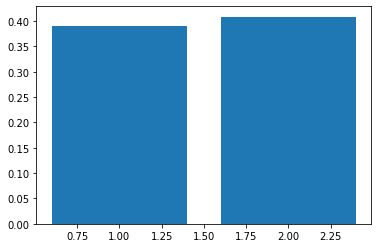

In [135]:
plt.bar([1,2],height=[np.mean(am_e_fish_list['duration_avg']),np.mean(am_me_fish_list['duration_avg'])])

In [137]:
np.mean(am_e_fish_list['duration_avg'])

0.3907528262913401

In [138]:
np.mean(am_me_fish_list['duration_avg'])

0.4085648750648562

In [139]:
stats.f_oneway(am_e_fish_list['duration_avg'],am_me_fish_list['duration_avg'])

F_onewayResult(statistic=7.725710276815084, pvalue=0.005708213515486395)

In [140]:
stats.ttest_ind(am_e_fish_list['duration_avg'],am_me_fish_list['duration_avg'])

Ttest_indResult(statistic=-2.7795161947388087, pvalue=0.005708213515485317)

{'whiskers': [<matplotlib.lines.Line2D at 0x13a0a2b20>,
 'caps': [<matplotlib.lines.Line2D at 0x13a0a2f70>,
 'boxes': [<matplotlib.lines.Line2D at 0x13a0a2850>],
 'medians': [<matplotlib.lines.Line2D at 0x13a0af580>],
 'fliers': [<matplotlib.lines.Line2D at 0x13a0af850>],
 'means': []}

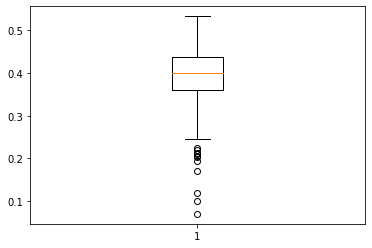

In [144]:
plt.boxplot(am_e_fish_list['duration_avg'])